### Autoencoder (AE) Examples of Complex-Valued Signal Denoising
Written by Amber Day, Natalie Klein, and Sinead Williamson

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import gridspec
from splitml.activations import ComplexReLU
from splitml.util import plot_complex_ts
from splitml.data import synthetic_data_gen
from splitml.losses import complex_mse
from scipy.fft import fft, ifft
from scipy.fftpack import fftfreq
from AE_training_functions import model_complex, model_dual_real1, model_dual_real2, model_dual_real1_concatenate

/home/neklein/anaconda3/envs/splitml_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Generation
***
Generate clean and noisy data sets and save parameters used in signal generation.

See `data_generation.py` for data generation function

In [2]:
(clean_training, noisy_training, clean_validation, noisy_validation, 
    clean_testing, noisy_testing, sig_params_training, sig_params_validation, 
    sig_params_testing, t) = synthetic_data_gen(N = 10000, nt = 1024, fs = 1./1.8e-05, 
    w_range = [-50,50], phi_range = [-np.pi, np.pi], T2_range = [1e-3, 1e-2], 
    sigma_range = [1e-3, 1e-2], A_range = [1,2], s = 1)

noisy_training = clean_training + noisy_training
noisy_validation = clean_validation + noisy_validation
noisy_testing = clean_testing + noisy_testing

Create plot of generated data.

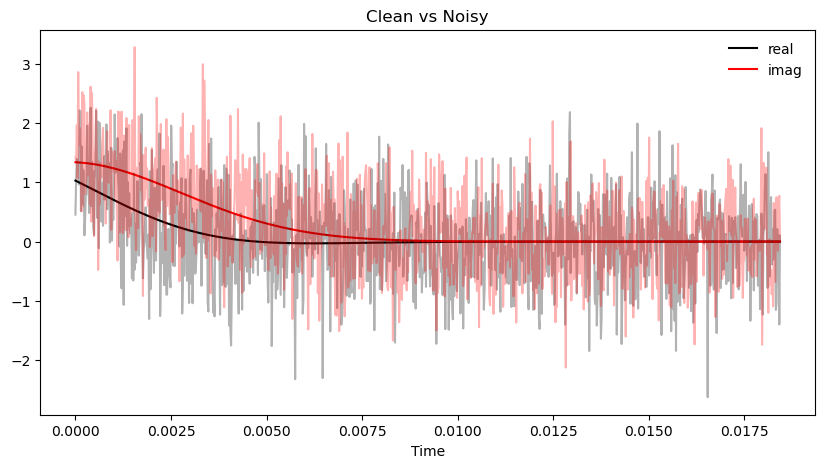

In [3]:
for i in range(1):
    fig = plt.figure() 
    fig.set_size_inches(10,5) 
    plot_complex_ts(t, clean_testing[i,:])
    plt.legend(frameon=False)
    plot_complex_ts(t, noisy_testing[i,:], alpha=0.3)
    plt.xlabel('Time')
    plt.title('Clean vs Noisy')
    plt.show()

### AE training
***
Train the models

See `trainings.py` for training functions

In [4]:
# Complex training
ModelComplexNet, loss_training, loss_validation, training_time = model_complex(clean_training = clean_training, 
    noisy_training = noisy_training, clean_validation = clean_validation, noisy_validation = noisy_validation, 
    activation = ComplexReLU(), loss_type = complex_mse, use_clean_training = True, use_clean_validation = True, 
    learning_rate = 0.01, patience = 5, epochs = 1000, seed = 1, time_points=len(t))

# DualReal1 training
ModelDualReal1, loss_training, loss_validation, training_time =  model_dual_real1(clean_training = clean_training, 
    noisy_training = noisy_training, clean_validation = clean_validation, noisy_validation = noisy_validation,
    activation = F.relu, loss_type = nn.MSELoss(), use_clean_training = True, use_clean_validation = True, 
    learning_rate = 0.01, patience = 5, epochs = 1000, seed = 1, time_points=len(t))

# DualReal2 training
ModelDualReal2Real, ModelDualReal2Imag, loss_training, loss_validation, training_time = model_dual_real2(
    clean_training = clean_training, noisy_training = noisy_training, clean_validation = clean_validation, 
    noisy_validation = noisy_validation,activation = F.relu, loss_type = nn.MSELoss(), 
    use_clean_training = True, use_clean_validation = True, learning_rate = 0.01, patience = 5, 
    epochs = 1000, seed = 1, time_points=len(t))

# DualReal1C training
ModelDualReal1C, loss_training, loss_validation, training_time = model_dual_real1_concatenate(
    clean_training = clean_training, noisy_training = noisy_training, clean_validation = clean_validation, 
    noisy_validation = noisy_validation,activation = F.relu, loss_type = nn.MSELoss(), 
    use_clean_training = True, use_clean_validation = True, learning_rate = 0.01, patience = 5, 
    epochs = 1000, seed = 1, time_points=len(t))

### AE Plotting
***
Prepare Data for Model Fit

In [5]:
device = torch.device('cpu') # set device
# Preparing Testing Data
noisy_testing_data = torch.tensor(noisy_testing).to(device).type(torch.complex64)
clean_testing_data = torch.tensor(clean_testing).to(device).type(torch.complex64)
noisy_testing_cat = torch.cat((noisy_testing_data.real, noisy_testing_data.imag),0)
# Fast Fourier Transform of Testing Data
freq = fftfreq(n=len(t), d=1.8e-05)
freq = np.fft.fftshift(freq)
fft_noisy = np.fft.fftshift(np.abs(fft(noisy_testing)))
fft_clean = np.fft.fftshift(np.abs(fft(clean_testing)))

Fit Models to Testing Data

In [6]:
# ComplexNet is fit on complex data
CNFitReal = (ModelComplexNet(noisy_testing_data).real).detach().numpy()
CNFitImag = (ModelComplexNet(noisy_testing_data).imag).detach().numpy()
CNFitComplex = (ModelComplexNet(noisy_testing_data)).detach().numpy()
CNFit = np.fft.fftshift(np.abs(fft(CNFitComplex))) # Fast Fourier Transform

# DualReal1 is fit on real and imaginary data respectively
DR1FitReal = (ModelDualReal1(noisy_testing_data.real)).detach().numpy()
DR1FitImag = (ModelDualReal1(noisy_testing_data.imag)).detach().numpy()
DR1FitComplex = DR1FitReal + DR1FitImag*1j
DR1Fit = np.fft.fftshift(np.abs(fft(DR1FitComplex)))# Fast Fourier Transform

# DualReal2 has two models fit on real and imaginary separately 
DR2FitReal = (ModelDualReal2Real(noisy_testing_data.real)).detach().numpy()
DR2FitImag = (ModelDualReal2Imag(noisy_testing_data.imag)).detach().numpy()
DR2FitComplex = DR2FitReal + DR2FitImag*1j
DR2Fit = np.fft.fftshift(np.abs(fft(DR2FitComplex)))# Fast Fourier Transform

# DualReal1C is fit on concatenated a real and imaginary dataset 
# then separated into real and imaginary
DR1CFit = (ModelDualReal1C(noisy_testing_cat)).detach().numpy()
DR1CFitReal = DR1CFit[0:2000] # first half is real data
DR1CFitImag = DR1CFit[2000:4000] # second half is imaginary data
DR1CFitComplex = DR1CFitReal + DR1CFitImag*1j
DR1CFit = np.fft.fftshift(np.abs(fft(DR1CFitComplex)))# Fast Fourier Transform

Plot of Results in the Time Domain and Frequency Domain

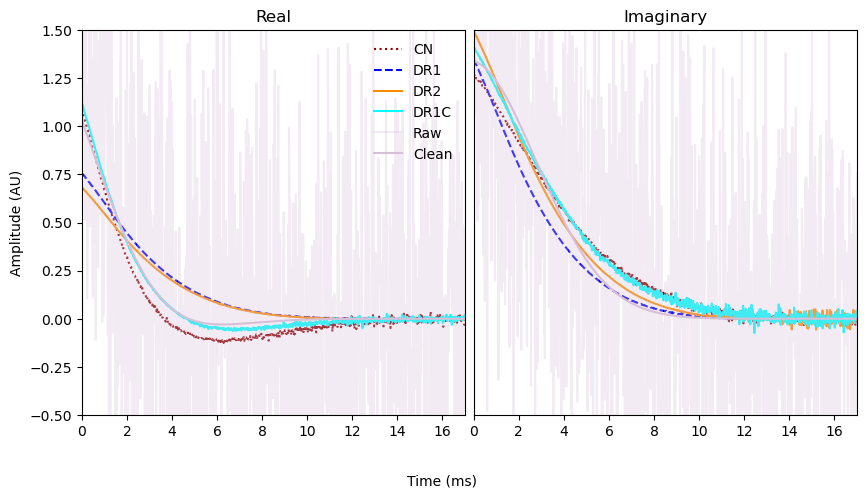

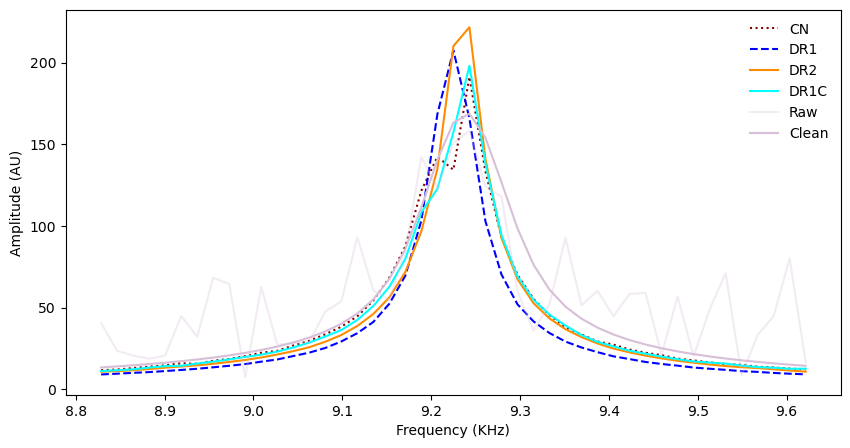

In [7]:
for row in range(1):
    ### Time Domain Plot ###
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.023) 
    fig.set_size_inches(10,5)
    fig.text(0.45, -.03, 'Time (ms)')

    # Real component plot
    ax1 = plt.subplot(gs[0,0])
    plt.plot((t*1000), CNFitReal[row,:], label="CN",color = 'darkred', linestyle='dotted')
    plt.plot((t*1000), DR1FitReal[row,:], label='DR1',color = 'b', linestyle='dashed')
    plt.plot((t*1000), DR2FitReal[row,:], label='DR2',color = 'darkorange')
    plt.plot((t*1000), DR1CFitReal[row,:], label='DR1C',color = 'aqua')
    plt.plot((t*1000), noisy_testing.real[row,:], alpha=0.3, label="Raw",color = 'thistle')
    plt.plot((t*1000), clean_testing.real[row,:], label="Clean",color = 'thistle')
    plt.ylabel('Amplitude (AU)')
    plt.ylim(-.5,1.5)
    plt.xlim(0,17)
    plt.title('Real')
    plt.legend(loc='upper right', frameon=False)
    
    # Imaginary component plot
    ax2 = plt.subplot(gs[0,1])
    plt.plot((t*1000), CNFitImag[row,:], label="CN",color = 'darkred', linestyle='dotted')
    plt.plot((t*1000), DR1FitImag[row,:], label='DR1',color = 'b', linestyle='dashed')
    plt.plot((t*1000), DR2FitImag[row,:], label='DR2',color = 'darkorange')
    plt.plot((t*1000), DR1CFitImag[row,:], label='DR1C',color = 'aqua')
    plt.plot((t*1000), noisy_testing.imag[row,:], alpha=0.3, label="Raw",color = 'thistle')
    plt.plot((t*1000), clean_testing.imag[row,:], label="Clean",color = 'thistle')
    plt.yticks([])
    plt.ylim(-.5,1.5)
    plt.xlim(0,17)
    plt.title('Imaginary')
    plt.show()
    

    ### Frequency Domain Plot ###
    fig = plt.figure()
    fig.set_size_inches(10,5)
    zoom = [490, 535]
    plt.plot((t[zoom[0]:zoom[1]]*1000), CNFit[row,zoom[0]:zoom[1]], label="CN",color = 'darkred', linestyle='dotted')
    plt.plot((t[zoom[0]:zoom[1]]*1000), DR1Fit[row,zoom[0]:zoom[1]], label='DR1',color = 'b', linestyle='dashed')
    plt.plot((t[zoom[0]:zoom[1]]*1000), DR2Fit[row,zoom[0]:zoom[1]], label='DR2',color = 'darkorange')
    plt.plot((t[zoom[0]:zoom[1]]*1000), DR1CFit[row,zoom[0]:zoom[1]], label='DR1C',color = 'aqua')
    plt.plot((t[zoom[0]:zoom[1]]*1000), fft_noisy[row,zoom[0]:zoom[1]], alpha=0.3, label="Raw",color = 'thistle')
    plt.plot((t[zoom[0]:zoom[1]]*1000), fft_clean[row,zoom[0]:zoom[1]], label="Clean",color = 'thistle')
    plt.xlabel("Frequency (KHz)")
    plt.ylabel('Amplitude (AU)')
    plt.legend(frameon=False)
    plt.show()
        

### AE $R^2$
***
Calculate MSE for comparison to no signal prediction for test set

In [8]:
# Create zero Vector
device = torch.device('cpu') # set device
z = np.zeros((2000,1024),dtype=complex)
z = torch.tensor(z).to(device).type(torch.complex64)
A = np.array(sig_params_testing["A"])
clean_testing_data = torch.tensor(clean_testing).to(device).type(torch.complex64)
# Rescale clean signal
for i in range(len(clean_testing_data)):
    clean_testing_data[i,:] = clean_testing_data[i,:]/A[i]
no_sig_mse = complex_mse(z, clean_testing_data).detach().numpy() # rescaled MSE for no signal prediction

Calculate MSE for AEs

In [9]:
# ComplexNet
for i in range(len(CNFitComplex)):
    CNFitComplex[i,:] = CNFitComplex[i,:]/A[i]
CN_mse = complex_mse(torch.tensor(CNFitComplex).to(device).type(torch.complex64), clean_testing_data).detach().numpy() # rescaled MSE

# DualReal1
for i in range(len(DR1FitComplex)):
    DR1FitComplex[i,:] = DR1FitComplex[i,:]/A[i]
DR1_mse = complex_mse(torch.tensor(DR1FitComplex).to(device).type(torch.complex64), clean_testing_data).detach().numpy() # rescaled MSE

# DualReal2
for i in range(len(DR2FitComplex)):
    DR2FitComplex[i,:] = DR2FitComplex[i,:]/A[i]
DR2_mse = complex_mse(torch.tensor(DR2FitComplex).to(device).type(torch.complex64), clean_testing_data).detach().numpy() # rescaled MSE

# DualReal1C
for i in range(len(DR1CFitComplex)):
    DR1CFitComplex[i,:] = DR1CFitComplex[i,:]/A[i]
DR1C_mse = complex_mse(torch.tensor(DR1CFitComplex).to(device).type(torch.complex64), clean_testing_data).detach().numpy() # rescaled MSE

Calculate $R^2$

In [10]:
CN_rsq = (1-CN_mse/no_sig_mse)
print("R sqared for Complex Net is", CN_rsq)
DR1_rsq = (1-DR1_mse/no_sig_mse)
print("R sqared for DualReal1 is", DR1_rsq)
DR2_rsq = (1-DR2_mse/no_sig_mse)
print("R sqared for DualReal2 is", DR2_rsq)
DR1C_rsq = (1-DR1C_mse/no_sig_mse)
print("R sqared for DualReal1C is", DR1C_rsq)

R sqared for Complex Net is 0.9534388147294521
R sqared for DualReal1 is 0.8711299747228622
R sqared for DualReal2 is 0.917725995182991
R sqared for DualReal1C is 0.965218111872673
